In [ ]:
#load the kaggle.json file
!pip install kaggle

from google.colab import files
files.upload()  # Upload kaggle.json

import os
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)



Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10
!unzip -q animals10.zip -d animals10


Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 96% 563M/586M [00:01<00:00, 328MB/s]
100% 586M/586M [00:01<00:00, 423MB/s]


In [ ]:
!ls animals10


raw-img  translate.py


In [ ]:
!ls animals10/raw-img


cane	 elefante  gallina  mucca   ragno
cavallo  farfalla  gatto    pecora  scoiattolo


In [ ]:
#import
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import shutil
import random

In [ ]:

raw_fol = "animals10/raw-img" #contains all images
base_fol = "animals10/split" #folder for the training , validation, and testing split images
#Folders for the training, validation, and testing images
train_fol = os.path.join(base_fol, "train")
val_fol   = os.path.join(base_fol, "val")
test_fol  = os.path.join(base_fol, "test")

#If they do not exists it creates the folders train, validation, and testing
for d in [train_fol, val_fol, test_fol]:
    os.makedirs(d, exist_ok=True)

classes = os.listdir(raw_fol)


#Goes through each class
for curr_class in classes:
    curr_class_fol = os.path.join(raw_fol, curr_class)
    images = os.listdir(curr_class_fol)
    random.shuffle(images) #mixes the images so the splits of training, validation, and testing are fairly equal
    x_total = len(images)
    x_train = int(0.8 * x_total) #80 images for training
    x_val   = int(0.1 * x_total) #10% images for validation / 10% for testing
    x_test  = x_total - x_train - x_val

    # Create subfolders(a folder for each class under train/validation/test)
    for split_fol in [train_fol, val_fol, test_fol]:
        os.makedirs(os.path.join(split_fol, curr_class), exist_ok=True)

    #Iterates through images to copy into the correct split
    for i, img_file in enumerate(images):
        og_loc = os.path.join(curr_class_fol, img_file)
        if i < x_train:
            dest = os.path.join(train_fol, curr_class, img_file)
        elif i < x_train + x_val:
            dest = os.path.join(val_fol, curr_class, img_file)
        else:
            dest = os.path.join(test_fol, curr_class, img_file)
        shutil.copyfile(og_loc, dest)

In [ ]:
img_size = (128,128)
batch_size = 32


#Train data generator alongside w/ data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#rescaling to thevalidation and testing generators
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


#creating generators
train_generator = train_datagen.flow_from_directory(
    train_fol,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_fol,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_fol,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False
)

#number of classes in the kaggle dataset being used
num_classes = len(train_generator.class_indices)


Found 20938 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 2627 images belonging to 10 classes.


In [ ]:
#This is the CNN
cnn = tf.keras.models.Sequential()


cnn.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(128,128,3)))
cnn.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))


cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(128, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))

cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))




/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,335,146 (16.54 MB)

 Trainable params: 4,335,146 (16.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#compile
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#train model
history = cnn.fit(train_generator,epochs=30,validation_data=val_generator,)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 144s 204ms/step - accuracy: 0.2187 - loss: 2.1645 - val_accuracy: 0.4059 - val_loss: 1.7927
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 124s 189ms/step - accuracy: 0.3772 - loss: 1.7862 - val_accuracy: 0.4637 - val_loss: 1.5757
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 123s 187ms/step - accuracy: 0.4776 - loss: 1.5311 - val_accuracy: 0.5050 - val_loss: 1.4411
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 122s 186ms/step - accuracy: 0.5167 - loss: 1.3971 - val_accuracy: 0.5746 - val_loss: 1.2501
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 119s 182ms/step - accuracy: 0.5537 - loss: 1.3064 - val_accuracy: 0.5884 - val_loss: 1.2401
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 122s 186ms/step - accuracy: 0.5742 - loss: 1.2337 - val_accuracy: 0.6171 - val_loss: 1.1207
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 122s 186ms/step - accuracy: 0.5935 - loss: 1.1897 - val_accuracy: 0.5425 - val_loss: 1.3278
Epoch 8/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 123s 187ms/step - accuracy: 0.6157 -

In [ ]:
#evaluate
score = cnn.evaluate(test_generator)


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7178 - loss: 0.8567
Test Accuracy: 71.95%


In [ ]:
#Loss
print('Total loss on Testing Set:', score[0])


In [ ]:
#Accuracy
print('Accuracy of Testing Set:', score[1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


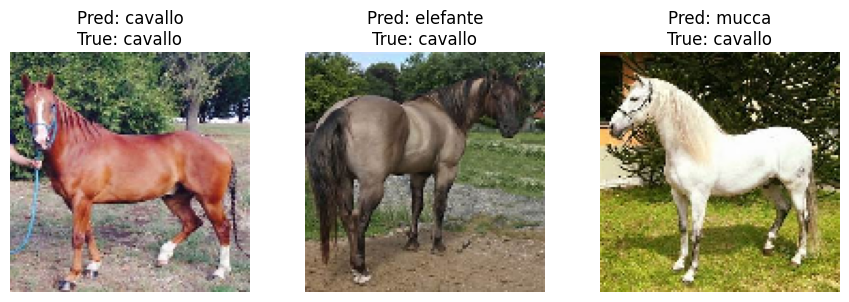

In [ ]:
#predict images


X_new, y_true = next(test_generator)

X_new, y_true = X_new[:3], y_true[:3]

# Predict class probabilities and round them (optional)
y_proba = cnn.predict(X_new)
y_proba.round(2)

y_pred = np.argmax(y_proba, axis=-1)

y_true_classes = np.argmax(y_true, axis=-1)

class_names = list(train_generator.class_indices.keys())

#Images displayed with predicted label and actual label
plt.figure(figsize=(7.2, 2.4))
for i, img in enumerate(X_new):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_names[y_pred[i]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

